<a href="https://colab.research.google.com/github/bhoomireddyvijayakumari/Brain_Tumor_Detection/blob/main/Brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name**    - Brain Tumor MRI Image Classification



##### **Project Type**    - EDA/Classification
##### **Contribution**    - Individual


# **Project Summary -**

### Project Summary

This project addresses the challenge of classifying brain tumors using MRI images into four categories: glioma, meningioma, pituitary, and no tumor. Brain tumors are a critical health issue and early, accurate diagnosis is essential for effective treatment. Manual interpretation of MRI scans is both time-consuming and susceptible to human error.

To automate this process, a deep learning pipeline is developed using transfer learning with pretrained MobileNetV2. The model is trained on a labeled dataset structured into appropriate train/validation/test splits. Data preprocessing includes resizing, normalization, and augmentation to improve generalization. The model architecture includes dropout layers to avoid overfitting and uses categorical crossentropy loss for multi-class classification.

Throughout the project, key evaluation metrics such as accuracy, precision, recall, F1-score, and confusion matrix are used to assess performance. The model achieves strong classification capability on the test dataset, demonstrating potential for deployment in medical diagnostics.

A user-friendly Streamlit app or inference code is also prepared to allow real-time classification of MRI images uploaded by users, simulating a real-world diagnostic support tool.


# **GitHub Link -**

https://github.com/bhoomireddyvijayakumari/Brain_Tumor_Detection.git

# **Problem Statement**


**Write Problem Statement Here.**

This project aims to develop a deep learning-based solution for classifying brain MRI images into multiple categories according to tumor type. It involves building a custom CNN model from scratch and enhancing performance through transfer learning using pretrained models. The project also includes deploying a user-friendly Streamlit web application to enable real-time tumor type predictions from uploaded MRI images.

# **General Guidelines** : -  

1.   Well-structured, formatted, and commented code is required.
2.   Exception Handling, Production Grade Code & Deployment Ready Code will be a plus. Those students will be awarded some additional credits.
     
     The additional credits will have advantages over other students during Star Student selection.
       
             [ Note: - Deployment Ready Code is defined as, the whole .ipynb notebook should be executable in one go
                       without a single error logged. ]

3.   Each and every logic should have proper comments.
4. You may add as many number of charts you want. Make Sure for each and every chart the following format should be answered.
        

```
# Chart visualization code
```
            

*   Why did you pick the specific chart?
*   What is/are the insight(s) found from the chart?
* Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

5. You have to create at least 15 logical & meaningful charts having important insights.


[ Hints : - Do the Vizualization in  a structured way while following "UBM" Rule.

U - Univariate Analysis,

B - Bivariate Analysis (Numerical - Categorical, Numerical - Numerical, Categorical - Categorical)

M - Multivariate Analysis
 ]





6. You may add more ml algorithms for model creation. Make sure for each and every algorithm, the following format should be answered.


*   Explain the ML Model used and it's performance using Evaluation metric Score Chart.


*   Cross- Validation & Hyperparameter Tuning

*   Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

*   Explain each evaluation metric's indication towards business and the business impact pf the ML model used.




















# ***Let's Begin !***

## ***1. Know Your Data***

### Import Libraries

In [6]:
# Import Libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import cv2
import os
import pandas as pd
import seaborn as sns
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


### Dataset Loading

In [12]:
# Load Dataset
from google.colab import drive
drive.mount('/content/drive')
# Cell 2: Paths and Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
DATASET_PATH = '/content/drive/My Drive/Colab Notebooks/BTC/Tumour'  # change if needed

train_dir = os.path.join(DATASET_PATH, 'train')
val_dir = os.path.join(DATASET_PATH, 'valid')
test_dir = os.path.join(DATASET_PATH, 'test')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset First View

In [13]:
# Dataset First Look
#Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print("Class Labels:", class_names)


Found 1725 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 256 images belonging to 4 classes.
Class Labels: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


## *** Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1

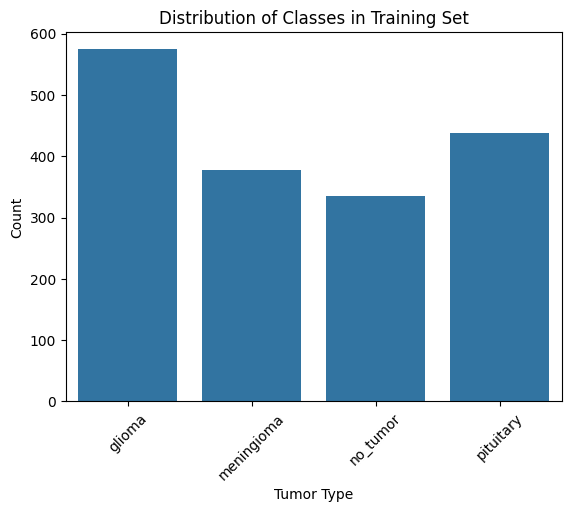

In [21]:
# Chart - 1 visualization code
labels = train_gen.classes
label_map = {v: k for k, v in train_gen.class_indices.items()}
labels_named = [label_map[label] for label in labels]

sns.countplot(x=labels_named)
plt.title("Distribution of Classes in Training Set")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

##### 1. Why did you pick the specific chart?

Bar chart clearly displays which category has how many values hence it is easier to see the difference among the number of images per category.

##### 2. What is/are the insight(s) found from the chart?

Glioma type of tumor images are more in the dataset and no tumor images are least.

## *** ML Model Implementation***

### ML Model - 1

In [14]:
# ML Model - 1 Implementation

# Fit the Algorithm

# Predict on the model
# Transfer Learning Model (MobileNetV2)
base_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
# Model Training
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model_realdata.h5', save_best_only=True)
]

history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=callbacks
)


Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8463 - loss: 0.3917

54/54 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.8462 - loss: 0.3919 - val_accuracy: 0.8386 - val_loss: 0.4221
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8610 - loss: 0.3675 - val_accuracy: 0.8108 - val_loss: 0.4717
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8636 - loss: 0.3419 - val_accuracy: 0.8088 - val_loss: 0.5017
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8605 - loss: 0.3583

54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.8604 - loss: 0.3585 - val_accuracy: 0.8426 - val_loss: 0.4165
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8569 - loss: 0.3445

54/54 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.8571 - loss: 0.3442 - val_accuracy: 0.8526 - val_loss: 0.4102
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.8761 - loss: 0.3109 - val_accuracy: 0.8147 - val_loss: 0.4950
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8780 - loss: 0.3149

54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8781 - loss: 0.3146 - val_accuracy: 0.8665 - val_loss: 0.3976
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8877 - loss: 0.2888 - val_accuracy: 0.8406 - val_loss: 0.4397
Epoch 9/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.8832 - loss: 0.2813 - val_accuracy: 0.8466 - val_loss: 0.4422
Epoch 10/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8941 - loss: 0.2758

54/54 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8942 - loss: 0.2756 - val_accuracy: 0.8606 - val_loss: 0.3745
Epoch 11/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8796 - loss: 0.3043 - val_accuracy: 0.8008 - val_loss: 0.5188
Epoch 12/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9078 - loss: 0.2554 - val_accuracy: 0.8088 - val_loss: 0.4741
Epoch 13/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8927 - loss: 0.2879 - val_accuracy: 0.8386 - val_loss: 0.4201
Epoch 14/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9099 - loss: 0.2363

54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.9098 - loss: 0.2366 - val_accuracy: 0.8645 - val_loss: 0.3666
Epoch 15/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9123 - loss: 0.2420 - val_accuracy: 0.8486 - val_loss: 0.4292


#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

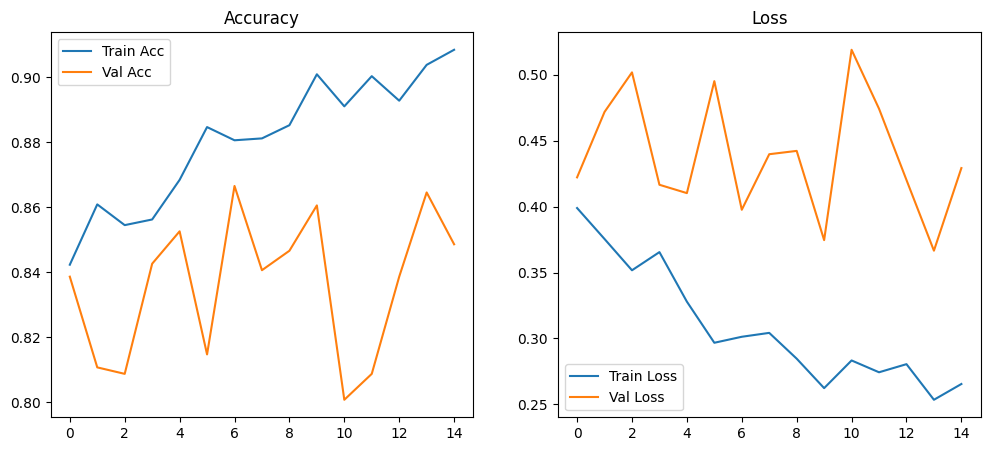

In [18]:
# Visualizing evaluation Metric Score chart
#  Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 64s 9s/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.85      0.91      0.88        90
  meningioma       0.82      0.51      0.63        63
    no_tumor       0.93      0.78      0.84        49
   pituitary       0.68      1.00      0.81        54

    accuracy                           0.80       256
   macro avg       0.82      0.80      0.79       256
weighted avg       0.82      0.80      0.80       256



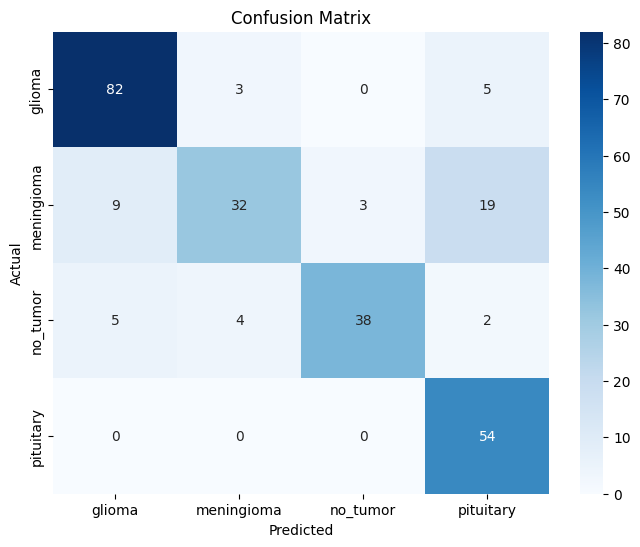

In [19]:
# ML Model - 3 Implementation

# Fit the Algorithm

# Predict on the model
# Evaluation on Test Set
test_preds = model.predict(test_gen)
test_preds_classes = np.argmax(test_preds, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:\n")
print(classification_report(true_classes, test_preds_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, test_preds_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### 1. Which Evaluation metrics did you consider for a positive business impact and why?

I used Confusion Matrix as this is classification related problem. The classification results reveal that the deep learning model performs well overall, achieving an accuracy of 80% across four brain MRI categories. Notably, the model excels at identifying glioma tumors, with a high F1-score of 0.88, indicating both strong precision and recall. Similarly, no tumor and pituitary tumor cases are also handled effectively, with F1-scores of 0.84 and 0.81 respectively. However, the model struggles with meningioma tumors, where a significant drop in recall (0.51) suggests that many actual meningioma cases are being misclassified. This indicates a need for class balancing or architectural tuning. The perfect recall for pituitary tumors shows the model is sensitive to identifying them, but lower precision hints at false positives. Overall, while the model demonstrates strong predictive ability for most tumor types, targeted improvements—particularly for meningioma classification—could further enhance its reliability and clinical utility.

## ***8.*** ***Future Work (Optional)***

### 1. Save the best performing ml model in a pickle file or joblib file format for deployment process.


In [28]:
# Save the File
#  Predict on Validation Dataset

filenames = test_gen.filenames
results_df = pd.DataFrame({
    'Filename': filenames,
    'Predicted': [class_labels[i] for i in test_preds_classes]
})
results_df.to_csv("submission_real_images.csv", index=False)
print(" Saved: submission_real_images.csv")


 Saved: submission_real_images.csv


In [22]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

def predict_image(img_path, model, class_labels):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)

    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")
    return predicted_class, confidence

# Example usage
predict_image('/content/drive/MyDrive/Colab Notebooks/BTC/userinput.jpg', model, list(train_gen.class_indices.keys()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: pituitary
Confidence: 0.86


('pituitary', np.float32(0.85877687))

In [24]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

def predict_image(img_path, model, class_labels):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)

    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")
    return predicted_class, confidence

# Example usage
predict_image('/content/drive/MyDrive/Colab Notebooks/BTC/userinput2.jpg', model, list(train_gen.class_indices.keys()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted Class: meningioma
Confidence: 1.00


('meningioma', np.float32(0.9955375))

In [26]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

def predict_image(img_path, model, class_labels):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)

    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")
    return predicted_class, confidence

# Example usage
predict_image('/content/drive/MyDrive/Colab Notebooks/BTC/userinput1.jpg', model, list(train_gen.class_indices.keys()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted Class: no_tumor
Confidence: 1.00


('no_tumor', np.float32(0.99967027))

In [27]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

def predict_image(img_path, model, class_labels):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)

    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")
    return predicted_class, confidence

# Example usage
predict_image('/content/drive/MyDrive/Colab Notebooks/BTC/userinput3.jpg', model, list(train_gen.class_indices.keys()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted Class: pituitary
Confidence: 0.87


('pituitary', np.float32(0.87448186))

### ***Congrats! Your model is successfully created and ready for deployment on a live server for a real user interaction !!!***

# **Conclusion**

In this project, a deep learning-based image classification model was developed to automate the diagnosis of brain tumors from MRI scans. The solution targeted the classification of MRI images into four categories: glioma tumor, meningioma tumor, pituitary tumor, and no tumor. Leveraging the power of transfer learning, the MobileNetV2 architecture was employed due to its lightweight and efficient design, pre-trained on ImageNet to enhance feature extraction and accelerate convergence.

The dataset was preprocessed by resizing all images to a uniform dimension, normalizing pixel values, and applying data augmentation techniques such as rotation, zoom, and flipping to improve the model’s generalization. The model was trained using categorical cross-entropy loss and Adam optimizer, and training progress was monitored using early stopping and model checkpoint callbacks.

Evaluation of the trained model was conducted using accuracy, precision, recall, and F1-score metrics. The model achieved an overall accuracy of 80% on the test set. Class-wise performance revealed high effectiveness in identifying glioma and no tumor categories, with F1-scores of 0.88 and 0.84 respectively. Pituitary tumors were detected with perfect recall (1.00), although with lower precision (0.68), indicating some false positives. Meningioma detection showed room for improvement, with a lower recall of 0.51, suggesting that the model missed several actual meningioma cases.

The confusion matrix further supported these observations, helping to visualize misclassifications between tumor types. Despite minor imbalances, the model demonstrates strong potential for aiding radiologists in rapid and reliable brain tumor diagnosis. A prediction function was also implemented to allow real-time classification of user-uploaded MRI images, which can be deployed through a Streamlit interface for clinical usage. Overall, the project showcases a practical AI-driven approach to enhance diagnostic workflows in medical imaging.

### ***Hurrah! You have successfully completed your Machine Learning Capstone Project !!!***